<a href="https://colab.research.google.com/github/stanley1208/AI-Learning/blob/main/TinyCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms



In [2]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:",device)
torch.manual_seed(0)

device: cuda


In [3]:
# transforms: to tensor + standard MNIST normalization
transform=transforms.Compose([
    transforms.ToTensor(),                        # [0,1]
    transforms.Normalize((0.1307,),(0.3081,))     # standard MNIST mean/std
])

In [4]:
# datasets
train_ds=datasets.MNIST(root="data", train=True, download=True, transform=transform)
test_ds=datasets.MNIST(root="data", train=False, download=True, transform=transform)

100%|██████████| 9.91M/9.91M [00:00<00:00, 59.4MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.69MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.9MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.6MB/s]


In [5]:
# dataloaders
train_loader=DataLoader(train_ds, batch_size=128, shuffle=True,num_workers=2,pin_memory=True)
test_loader=DataLoader(test_ds, batch_size=256, shuffle=False,num_workers=2,pin_memory=True)


In [6]:
# sanity peek
x0,y0=next(iter(train_loader))
print(x0.shape,y0.shape)

torch.Size([128, 1, 28, 28]) torch.Size([128])


In [12]:
class TinyCNN(nn.Module):
  def __init__(self,):
    super().__init__()
    self.features=nn.Sequential(
        nn.Conv2d(1,8,kernel_size=3,padding=1),     # 28x28 -> 28x28, channels: 1->8
        nn.ReLU(),
        nn.MaxPool2d(2),                            # 28x28 -> 14x14
        nn.Conv2d(8,16,kernel_size=3,padding=1),    # 14x14 -> 14x14, 8->16
        nn.ReLU(),
        nn.MaxPool2d(2)                             # 14x14 -> 7x7
    )

    self.classifier=nn.Sequential(
        nn.Flatten(),   # 16x7x7=784 features
        nn.Linear(16*7*7,64),
        nn.ReLU(),
        nn.Linear(64,10)  # 10 logits for classes 0..9
    )
  def forward(self,x):
    x=self.features(x)
    x=self.classifier(x)
    return x

model=TinyCNN().to(device)
print(model)

TinyCNN(
  (features): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=64, bias=True)
    (2): ReLU()
    (3): Linear(in_features=64, out_features=10, bias=True)
  )
)


In [8]:
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(),lr=1e-3)


In [9]:
def train_epoch(model,loader,criterion,optimizer,device):
  model.train()
  total,correct,total_loss=0.0,0,0
  for xb,yb in loader:
    xb,yb=xb.to(device),yb.to(device)
    logits=model(xb)  # forward
    loss=criterion(logits,yb)   # compute loss

    optimizer.zero_grad()   # clear old grads
    loss.backward()   # compute gradients
    optimizer.step()  # update weights

    total_loss+=loss.item()*xb.size(0)
    preds=logits.argmax(dim=1)
    correct+=torch.sum(preds==yb).sum().item()
    total+=xb.size(0)
  return total_loss/total,correct/total

In [10]:
@torch.no_grad()
def eval_epoch(model,loader,criterion,device):
  model.eval()
  total,correct,total_loss=0,0,0.0
  for xb,yb in loader:
    xb,yb=xb.to(device),yb.to(device)
    logits=model(xb)
    loss=criterion(logits,yb)
    total_loss+=loss.item()*xb.size(0)
    preds=logits.argmax(dim=1)
    correct+=torch.sum(preds==yb).sum().item()
    total+=xb.size(0)
  return total_loss/total,correct/total

In [11]:
epochs=3
for epoch in range(1,epochs+1):
  tr_loss,tr_acc=train_epoch(model,train_loader,criterion,optimizer,device)
  te_loss,te_acc=eval_epoch(model,test_loader,criterion,device)
  print(f"Epoch {epoch:02d} | "
          f"train loss {tr_loss:.4f} acc {tr_acc:.3f} | "
          f"test loss {te_loss:.4f} acc {te_acc:.3f}")

Epoch 01 | train loss 0.3068 acc 0.916 | test loss 0.0928 acc 0.972
Epoch 02 | train loss 0.0837 acc 0.975 | test loss 0.0714 acc 0.976
Epoch 03 | train loss 0.0598 acc 0.982 | test loss 0.0501 acc 0.983


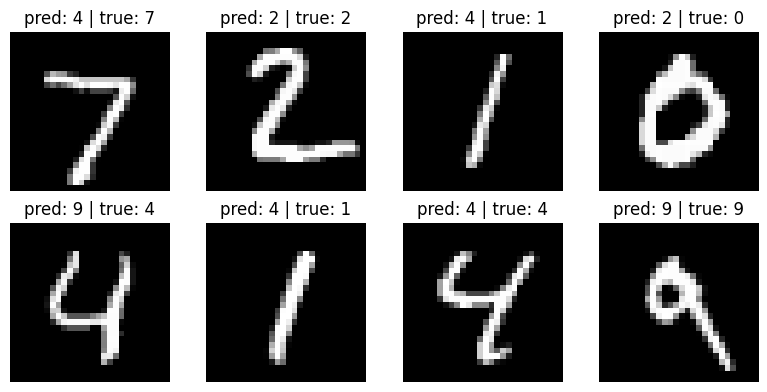

In [15]:
import matplotlib.pyplot as plt

# evaluation mode disables dropout etc.
model.eval()

# get one mini-batch from test_loader
xb,yb=next(iter(test_loader))
xb,yb=xb.to(device),yb.to(device)

# forward pass
with torch.no_grad():
  logits=model(xb)
  preds=logits.argmax(dim=1)

# move back to CPU for plotting
xb=xb.cpu()
yb=yb.cpu()
preds=preds.cpu()

# plot
fig,axes=plt.subplots(2,4,figsize=(8,4))
for i,ax in enumerate(axes.flat):
  ax.imshow(xb[i,0],cmap="gray")
  ax.set_title(f"pred: {preds[i].item()} | true: {yb[i].item()}")
  ax.axis("off")
plt.tight_layout()
plt.show()



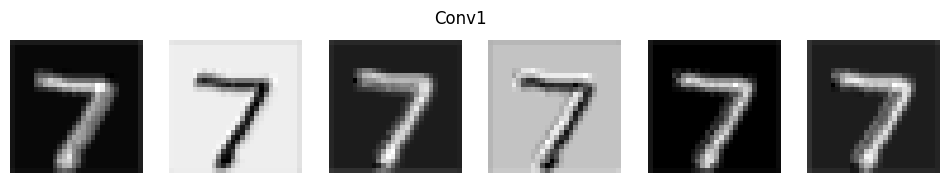

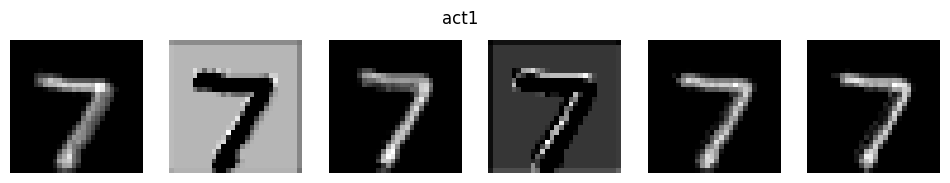

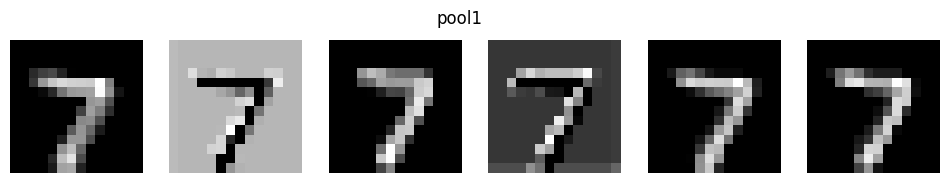

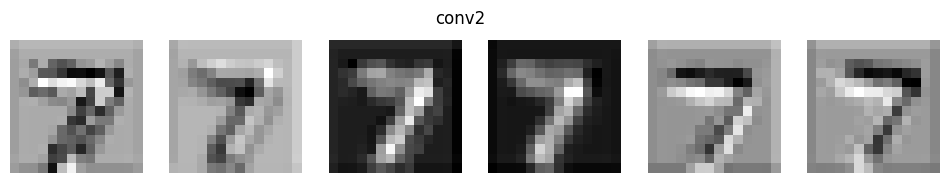

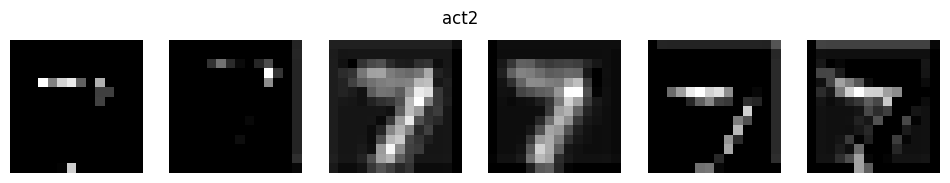

In [16]:
# choose one image from the test set
image=xb[0].unsqueeze(0).to(device) # shape [1,1,28,28]

# forward through the feature extractor only
with torch.no_grad():
  conv1=model.features[0](image)  # Conv1 output
  act1=model.features[1](conv1)   # ReLU
  pool1=model.features[2](act1)   # MaxPool
  conv2=model.features[3](pool1)  # Conv2
  act2=model.features[4](conv2)   # ReLU


# helper to visualize feature maps
def show_feature_map(tensor,title,num_ch=6):
  fmap=tensor[0].detach().cpu()
  ch=min(fmap.shape[0],num_ch)
  fig,axes=plt.subplots(1,ch,figsize=(2*ch,2))
  fig.suptitle(title)
  for i in range(ch):
    axes[i].imshow(fmap[i],cmap="gray")
    axes[i].axis("off")
  plt.show()

show_feature_map(conv1,"Conv1",num_ch=6)
show_feature_map(act1,"act1",num_ch=6)
show_feature_map(pool1,"pool1",num_ch=6)
show_feature_map(conv2,"conv2",num_ch=6)
show_feature_map(act2,"act2",num_ch=6)

In [17]:
x=torch.randn(1,1,28,28)
for (k,p,s) in [(3,0,1), (3,1,1), (5,2,1), (3,1,2)]:
  conv=nn.Conv2d(1,1,kernel_size=k,padding=p,stride=s,bias=False)
  y=conv(x)
  print(f"kernel={k}, padding={p}, stride={s} -> output shape {tuple(y.shape)}")


kernel=3, padding=0, stride=1 -> output shape (1, 1, 26, 26)
kernel=3, padding=1, stride=1 -> output shape (1, 1, 28, 28)
kernel=5, padding=2, stride=1 -> output shape (1, 1, 28, 28)
kernel=3, padding=1, stride=2 -> output shape (1, 1, 14, 14)
